In [5]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Load bond data
bond_data = pd.read_csv("Final_Bond_Data.csv")

# Convert date columns to datetime objects
bond_data['next_coupon_date'] = pd.to_datetime(bond_data['next_coupon_date'])
bond_data['maturity_date'] = pd.to_datetime(bond_data['maturity_date'])

# Add the num_coupon_payments column
bond_data['num_coupon_payments'] = range(1, len(bond_data) + 1)

# Define function to calculate YTM for "zero-coupon" bonds
def calculate_single_payment_ytm(dirty_price, total_payment, time_to_maturity):
    return (total_payment / dirty_price) ** (1 / time_to_maturity) - 1

# Define function to calculate YTM using Newton's Method for multi-payment bonds
def calculate_ytm_newton(dirty_price, coupon_rate, next_coupon_date, num_coupon_payments, today, face_value=100, tol=1e-6, max_iter=100):
    # Generate payment schedule
    payment_dates = [next_coupon_date + relativedelta(months=6 * i) for i in range(num_coupon_payments)]
    time_to_payments = [(date - today).days / 365 for date in payment_dates]
    payments = [coupon_rate * face_value / 2] * (num_coupon_payments - 1) + [
        coupon_rate * face_value / 2 + face_value
    ]

    # Define YTM equation and its derivative
    def ytm_equation(r):
        return sum(p / (1 + r / 2) ** (2 * t) for p, t in zip(payments, time_to_payments)) - dirty_price

    def ytm_equation_derivative(r):
        return sum(
            -2 * t * p / (1 + r / 2) ** (2 * t + 1) for p, t in zip(payments, time_to_payments)
        )

    # Initial guess for YTM
    r = 0.05

    for i in range(max_iter):
        f_r = ytm_equation(r)
        f_r_prime = ytm_equation_derivative(r)

        r_next = r - f_r / f_r_prime

        if abs(r_next - r) < tol:
            return r_next  # Converged YTM

        r = r_next

# List of dates for which YTM is calculated
dates = [
    datetime(2025, 1, 6),
    datetime(2025, 1, 7),
    datetime(2025, 1, 8),
    datetime(2025, 1, 9),
    datetime(2025, 1, 10),
    datetime(2025, 1, 13),
    datetime(2025, 1, 14),
    datetime(2025, 1, 15),
    datetime(2025, 1, 16),
    datetime(2025, 1, 17)
]

# Calculate YTMs for all bonds and dates
for date in dates:
    dirty_price_column = f'{date.strftime("%b").lower()}_{date.day}_dirty'
    if dirty_price_column not in bond_data.columns:
        raise ValueError(f"Missing dirty price column: {dirty_price_column}")

    def compute_ytm(row):
        dirty_price = row[dirty_price_column]
        face_value = 100
        time_to_maturity = (row['maturity_date'] - date).days / 365
        coupon_rate = row['coupon_rate']
        num_coupon_payments = row['num_coupon_payments']
        next_coupon_date = row['next_coupon_date']

        if num_coupon_payments == 1:  # Single-payment bond (zero-coupon-like)
            total_payment = face_value + (coupon_rate * face_value / 2)
            return calculate_single_payment_ytm(dirty_price, total_payment, time_to_maturity)
        else:  # Multi-payment bond
            return calculate_ytm_newton(dirty_price, coupon_rate, next_coupon_date, num_coupon_payments, today=date)

    # Apply the computation for the current date
    bond_data[f'YTM_{date.strftime("%b_%d")}'] = bond_data.apply(compute_ytm, axis=1)

# Display results
bond_data[[col for col in bond_data.columns if col.startswith('YTM_')]]

,YTM_Jan_06,YTM_Jan_07,YTM_Jan_08,YTM_Jan_09,YTM_Jan_10,YTM_Jan_13,YTM_Jan_14,YTM_Jan_15,YTM_Jan_16,YTM_Jan_17
0,0.031803,0.031703,0.031599,0.032229,0.032132,0.034217,0.034974,0.031582,0.031457,0.030454
1,0.030019,0.029829,0.030117,0.029925,0.030859,0.031427,0.031565,0.030882,0.029863,0.029498
2,0.029338,0.029500,0.029663,0.029459,0.030452,0.030583,0.031683,0.030827,0.029875,0.029480
3,0.028643,0.028819,0.028804,0.028597,0.029736,0.030405,0.030845,0.029990,0.028811,0.028601
4,0.028887,0.029023,0.029111,0.028851,0.030082,0.030701,0.031193,0.030331,0.029168,0.029006
5,0.028941,0.029250,0.029321,0.029154,0.030380,0.030959,0.031394,0.030706,0.029497,0.029370
6,0.028916,0.028910,0.029301,0.029229,0.029888,0.030774,0.031575,0.030831,0.029688,0.029448
7,0.029278,0.029158,0.029586,0.029726,0.030156,0.031045,0.031920,0.031242,0.029777,0.029481
8,0.029521,0.029668,0.029942,0.030014,0.030847,0.031449,0.032213,0.031571,0.030142,0.029884
9,0.029828,0.030007,0.030233,0.030367,0.031262,0.031995,0.032644,0.032013,0.030666,0.030386


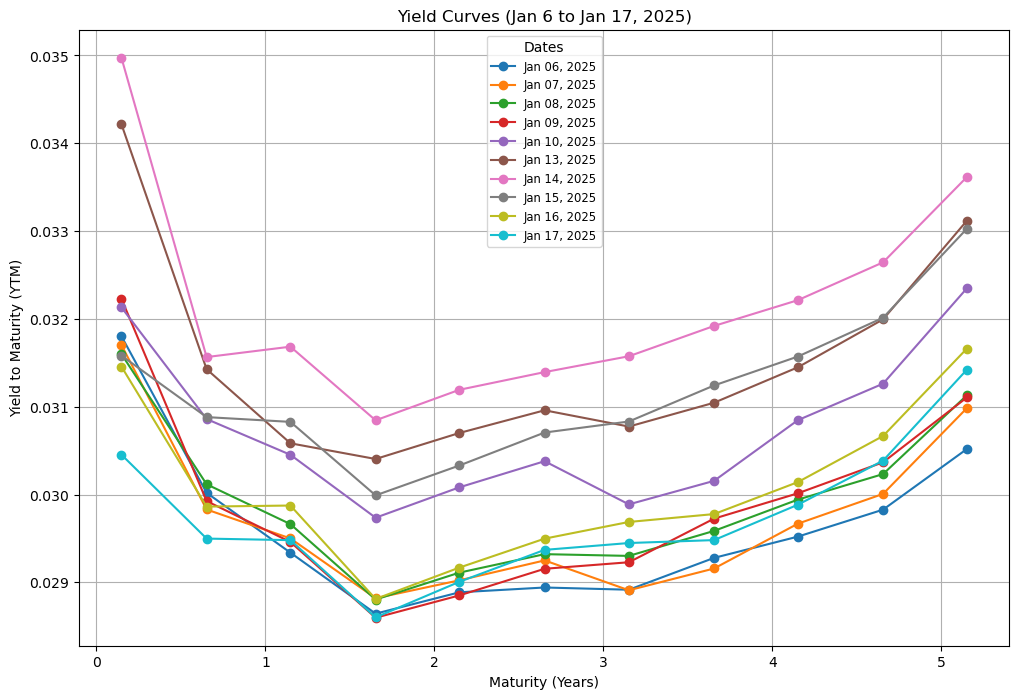

In [6]:
import matplotlib.pyplot as plt
from datetime import datetime

# Convert maturity_date to years from starting date (Jan 6)
today = datetime(2025, 1, 6)
bond_data['maturity_years'] = (bond_data['maturity_date'] - today).dt.days / 365

# List of dates used in the YTM calculation
dates = [
    datetime(2025, 1, 6),
    datetime(2025, 1, 7),
    datetime(2025, 1, 8),
    datetime(2025, 1, 9),
    datetime(2025, 1, 10),
    datetime(2025, 1, 13),
    datetime(2025, 1, 14),
    datetime(2025, 1, 15),
    datetime(2025, 1, 16),
    datetime(2025, 1, 17)
]

# Plot the YTMs for each date
plt.figure(figsize=(12, 8))

for date in dates:
    column_name = f'YTM_{date.strftime("%b_%d")}'
    plt.plot(
        bond_data['maturity_years'],
        bond_data[column_name],
        marker='o',
        linestyle='-',
        label=date.strftime('%b %d, %Y')
    )

# Labeling the graph
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield to Maturity (YTM)')
plt.title('Yield Curves (Jan 6 to Jan 17, 2025)')
plt.grid(True)
plt.legend(title='Dates', fontsize='small')
plt.show()


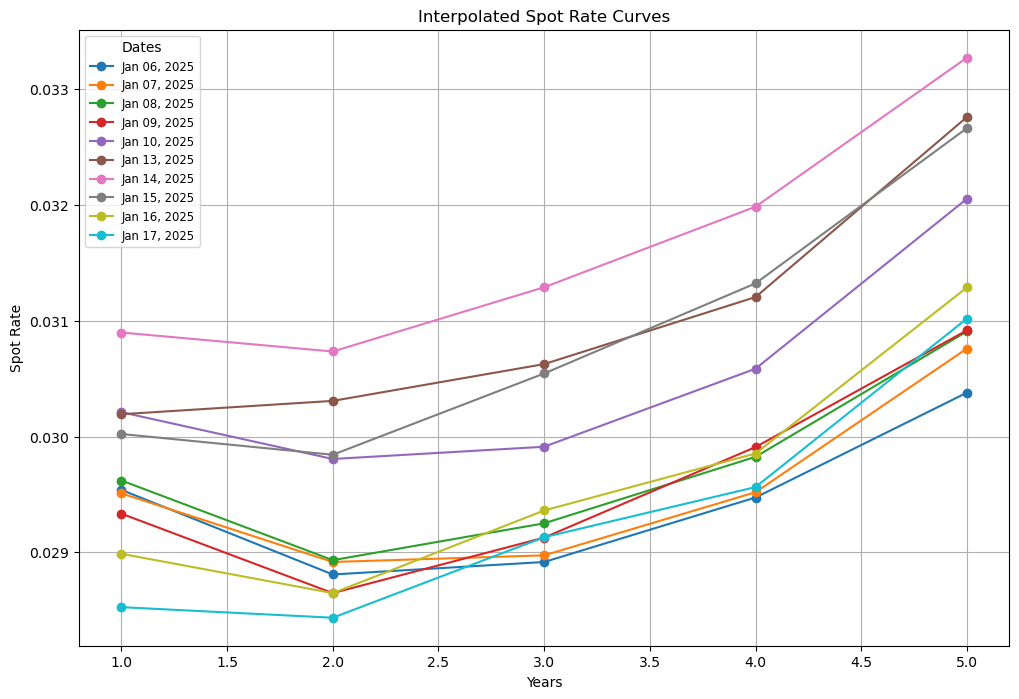

In [8]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Define function to compute spot rates for all dates and interpolate
def compute_and_plot_interpolated_spot_rates(bond_data, dates, target_maturities):
    interpolated_data = {}  # Store interpolated spot rates for each date

    # Iterate through all specified dates
    for date in dates:
        spot_rates = []  # Store spot rates for the current date
        dirty_price_column = f'{date.strftime("%b").lower()}_{date.day}_dirty'

        # Sort bonds by maturity for bootstrapping
        bond_data_sorted = bond_data.sort_values('maturity_date')

        # Initialize empty list to hold spot rates for the current date
        maturities = []  # Store maturities in years
        for idx, row in bond_data_sorted.iterrows():
            dirty_price = row[dirty_price_column]
            coupon_rate = row['coupon_rate']
            face_value = 100
            next_coupon_date = row['next_coupon_date']
            num_coupon_payments = row['num_coupon_payments']

            # Generate payment schedule
            payment_dates = [next_coupon_date + relativedelta(months=6 * i) for i in range(num_coupon_payments)]
            time_to_payments = [(date - today).days / 365 for date in payment_dates]
            payments = [coupon_rate * face_value / 2] * (num_coupon_payments - 1) + [
                coupon_rate * face_value / 2 + face_value
            ]

            # Compute spot rates
            if idx == 0:  # First bond (earliest maturity)
                spot_rate = row[f'YTM_{date.strftime("%b_%d")}']  # Spot rate is YTM for first bond
            else:
                discounted_sum = sum(
                    payments[i] / (1 + spot_rates[i] / 2) ** (2 * time_to_payments[i])
                    for i in range(len(spot_rates))
                )
                total_payment = payments[-1]
                time_to_maturity = time_to_payments[-1]

                # Solve for spot rate
                spot_rate = 2 * (
                    (total_payment / (dirty_price - discounted_sum)) ** (1 / (2 * time_to_maturity)) - 1
                )

            spot_rates.append(spot_rate)  # Append the computed spot rate
            maturities.append(time_to_payments[-1])  # Append the maturity in years

        # Interpolate spot rates for the target maturities
        interpolator = interp1d(maturities, spot_rates, kind='linear', fill_value='extrapolate')
        interpolated_spot_rates = interpolator(target_maturities)
        interpolated_data[date.strftime('%b %d, %Y')] = interpolated_spot_rates

    # Convert the interpolated data into a DataFrame for plotting
    interpolated_df = pd.DataFrame(interpolated_data, index=target_maturities)
    interpolated_df.index.name = 'Maturity (Years)'

    # Plot the interpolated spot rates for all dates
    plt.figure(figsize=(12, 8))
    for date in interpolated_df.columns:
        plt.plot(interpolated_df.index, interpolated_df[date], marker='o', label=date)

    # Finalize the plot
    plt.xlabel('Years')
    plt.ylabel('Spot Rate')
    plt.title('Interpolated Spot Rate Curves')
    plt.grid(True)
    plt.legend(title='Dates', loc='upper left', fontsize='small')
    plt.show()

    # Return the interpolated DataFrame
    return interpolated_df

# Target maturities (in years) to interpolate spot rates
target_maturities = [1, 2, 3, 4, 5]

# List of dates for which rates will be calculated
dates = [
    datetime(2025, 1, 6),
    datetime(2025, 1, 7),
    datetime(2025, 1, 8),
    datetime(2025, 1, 9),
    datetime(2025, 1, 10),
    datetime(2025, 1, 13),
    datetime(2025, 1, 14),
    datetime(2025, 1, 15),
    datetime(2025, 1, 16),
    datetime(2025, 1, 17)
]

# Compute and plot interpolated spot rates for all dates
interpolated_spot_rates_df = compute_and_plot_interpolated_spot_rates(bond_data, dates, target_maturities)


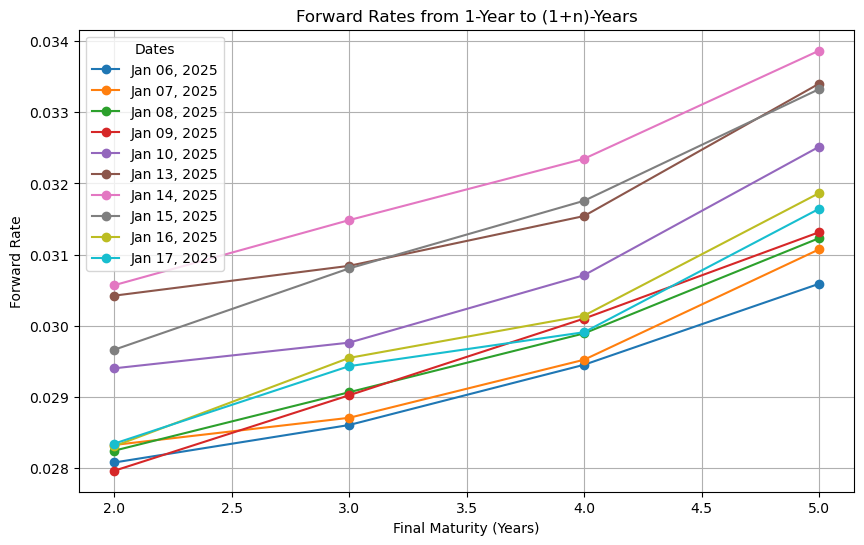

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_forward_from_year1(df):
    """
    Computes & plots F_{1->(1+n)} for n=1..4, on one chart
    """
    final_maturities = [2,3,4,5]  # We'll do F_{1->2}, F_{1->3}, F_{1->4}, F_{1->5}
    forward_rates = pd.DataFrame(index=final_maturities, columns=df.columns, dtype=float)

    for date_col in df.columns:
        S_1 = df.loc[1, date_col]  # spot yield at 1-year
        for m in final_maturities:
            S_m = df.loc[m, date_col]  # spot yield at maturity m
            n = m - 1  # horizon length
            # ratio of discount factors:
            ratio = ((1 + S_m/2)**(2*m)) / ((1 + S_1/2)**(2*1))
            # semiannual-effective forward rate per half-year:
            f_halfyear = ratio**(1/(2*n)) - 1

            F_nominal_sa = 2 * f_halfyear
            forward_rates.loc[m, date_col] = F_nominal_sa

    # Plot on one figure
    plt.figure(figsize=(10,6))
    for date_col in forward_rates.columns:
        plt.plot(
            forward_rates.index, 
            forward_rates[date_col].values, 
            marker='o', 
            label=str(date_col)
        )

    plt.title("Forward Rates from 1-Year to (1+n)-Years")
    plt.xlabel("Final Maturity (Years)")
    plt.ylabel("Forward Rate")
    plt.grid(True)
    plt.legend(title='Dates')
    plt.show()

    return forward_rates

forward_df = plot_forward_from_year1(interpolated_spot_rates_df)

In [9]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Step 1: Interpolate YTM Data for 1yr, 2yr, ..., 5yr
def interpolate_yield_curve(bond_data, dates, target_maturities):
    """
    Interpolate the yield curve for given target maturities using bond YTMs.
    """
    interpolated_yields = {}

    for date in dates:
        ytm_column = f'YTM_{date.strftime("%b_%d")}'
        if ytm_column not in bond_data.columns:
            raise ValueError(f"YTM column {ytm_column} not found in bond data.")

        # Extract maturity in years and YTM values
        actual_maturities = (bond_data['maturity_date'] - date).dt.days / 365
        actual_ytms = bond_data[ytm_column]

        # Perform interpolation
        interpolator = interp1d(
            actual_maturities,
            actual_ytms,
            kind='linear',
            fill_value='extrapolate'
        )
        interpolated_yields[date.strftime('%b %d, %Y')] = interpolator(target_maturities)

    # Create DataFrame for interpolated yield curves
    interpolated_yield_curve_df = pd.DataFrame(
        interpolated_yields, index=target_maturities
    )
    interpolated_yield_curve_df.index.name = 'Maturity (Years)'

    return interpolated_yield_curve_df

# Step 2: Compute Log-Returns
def compute_log_returns_yields(interpolated_yield_curve_df):
    """
    Compute log-returns for the interpolated yield curve.
    For each maturity, compute log(r_{i,j+1}/r_{i,j}).
    """
    log_returns = np.log(
        interpolated_yield_curve_df.iloc[:, 1:].values  # r_{i,j+1}
        / interpolated_yield_curve_df.iloc[:, :-1].values  # r_{i,j}
    )
    return pd.DataFrame(
        log_returns,
        columns=interpolated_yield_curve_df.columns[1:],  # Dates j+1
        index=interpolated_yield_curve_df.index  # Maturities i
    )

# Step 3: Compute Covariance Matrix
def compute_covariance_matrix(log_returns_df):
    """
    Compute the covariance matrix of log-returns.
    """
    return pd.DataFrame(
        np.cov(log_returns_df.values),  # Use all log-returns as variables
        index=log_returns_df.index,
        columns=log_returns_df.index
    )

# Inputs
target_maturities = [1, 2, 3, 4, 5]
dates = [
    datetime(2025, 1, 6),
    datetime(2025, 1, 7),
    datetime(2025, 1, 8),
    datetime(2025, 1, 9),
    datetime(2025, 1, 10),
    datetime(2025, 1, 13),
    datetime(2025, 1, 14),
    datetime(2025, 1, 15),
    datetime(2025, 1, 16),
    datetime(2025, 1, 17),
]

# Interpolated Yields
interpolated_yield_curve_df = interpolate_yield_curve(bond_data, dates, target_maturities)

# Log-Returns
yield_log_returns_df = compute_log_returns_yields(interpolated_yield_curve_df)

# Covariance Matrix for Log-Returns
yield_cov_matrix = compute_covariance_matrix(yield_log_returns_df)

# Display Results

print("\nCovariance Matrix for Yield Log-Returns:")
yield_cov_matrix



Covariance Matrix for Yield Log-Returns:


Maturity (Years),1,2,3,4,5
Maturity (Years),,,,,
1,0.000476,0.000507,0.000468,0.000478,0.000474
2,0.000507,0.000604,0.000537,0.000537,0.000566
3,0.000468,0.000537,0.000515,0.000528,0.000518
4,0.000478,0.000537,0.000528,0.000560,0.000535
5,0.000474,0.000566,0.000518,0.000535,0.000556


In [10]:
import numpy as np
import pandas as pd

def compute_forward_covariance(forward_df):
    """
    Given a DataFrame 'forward_rate_df', computes daily log returns of each forward horizon
    and returns the covariance matrix of these log returns.
    """
    # Transpose: row=dates, columns=forward horizons
    df_T = forward_df.T
    
    # 2) Compute daily log returns along the time axis (row‐wise)
    log_returns = np.log(df_T / df_T.shift(1))
    
    # Drop the first row of NaNs created by the shift
    log_returns = log_returns.dropna(axis=0, how='any')
    
    # 3) Covariance matrix across the forward horizons
    cov_matrix = log_returns.cov()
    
    return log_returns, cov_matrix

log_ret_df, forward_cov = compute_forward_covariance(forward_df)

print("Log‐returns of forward rates:\n", log_ret_df)
print("\nCovariance matrix of log‐returns:\n")
forward_cov

Log‐returns of forward rates:
                      2         3         4         5
Jan 07, 2025  0.008741  0.003532  0.002399  0.015686
Jan 08, 2025 -0.002830  0.012450  0.012473  0.005051
Jan 09, 2025 -0.010041 -0.001464  0.006937  0.002682
Jan 10, 2025  0.050202  0.025155  0.020068  0.037629
Jan 13, 2025  0.034147  0.035629  0.026699  0.026912
Jan 14, 2025  0.004834  0.020631  0.025211  0.013804
Jan 15, 2025 -0.030122 -0.021805 -0.018430 -0.016108
Jan 16, 2025 -0.046769 -0.041679 -0.052168 -0.044851
Jan 17, 2025  0.001264 -0.003938 -0.007771 -0.006943

Covariance matrix of log‐returns:



,2,3,4,5
2,0.000873,0.000645,0.000616,0.000689
3,0.000645,0.000579,0.000586,0.000556
4,0.000616,0.000586,0.000632,0.000572
5,0.000689,0.000556,0.000572,0.000600


In [11]:
import numpy as np
from numpy.linalg import eig

def sorted_and_scaled_eigs(cov_matrix):
    vals, vecs = eig(cov_matrix)
    
    # 1) Sort by descending eigenvalue
    idx = np.argsort(vals)[::-1] 
    vals = vals[idx]
    vecs = vecs[:, idx]          

    # 2) Scale each column vector so that its last component = 1
    for i in range(vecs.shape[1]):
        scale_factor = 1.0 / vecs[-1, i]
        vecs[:, i] *= scale_factor
    
    return vals, vecs

x, y = sorted_and_scaled_eigs(yield_cov_matrix)
w, v = sorted_and_scaled_eigs(forward_cov)

print("Eigenvalues for Yield Rates (descending):", x)
print("Eigenvectors for Yield Rates (last component=1):\n", y)

print("\nEigenvalues for Forward Rates (descending):", w)
print("Eigenvectors for Forward Rates (last component=1):\n", v)


Eigenvalues for Yield Rates (descending): [2.60668098e-03 5.07091900e-05 4.16195656e-05 1.14642452e-05
 1.71318649e-06]
Eigenvectors for Yield Rates (last component=1):
 [[  0.90542635 -13.31658718  -1.39064138   0.4539764    0.31397409]
 [  1.03851116 -15.23977265   0.726028    -0.55881083  -1.25313918]
 [  0.96802148   7.44390296  -0.11697618  -1.10555637   1.37866428]
 [  0.99513333  19.77423957  -0.38349572   0.24066263  -1.32390102]
 [  1.           1.           1.           1.           1.        ]]

Eigenvalues for Forward Rates (descending): [2.51681129e-03 1.36964461e-04 2.65618753e-05 3.86979010e-06]
Eigenvectors for Forward Rates (last component=1):
 [[ 1.17297459  7.74481667 -0.29645495 -0.79767185]
 [ 0.97685023 -3.06599668 -0.85566533  1.17894356]
 [ 0.99018976 -7.15969195  0.18540991 -1.22804994]
 [ 1.          1.          1.          1.        ]]
